In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
import jax.numpy as jnp
from jax.experimental import host_callback
from tqdm.auto import tqdm
from functools import partial
import frozen_lake
import plotting
import qlearning
import actions
import mangoenv
import utils


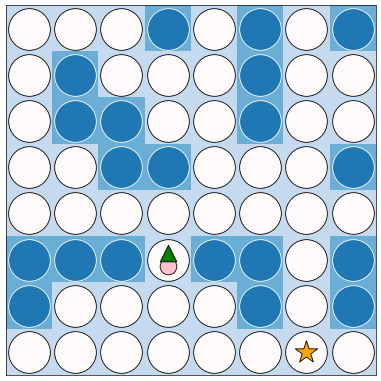

In [2]:
seed = 0
map_scale = 3

max_steps = 2**20
rollout_steps = 4**map_scale
n_rollouts = max_steps // rollout_steps
batch_size = 8 * rollout_steps

rng_env, rng_steps, rng_init =  jax.random.split(jax.random.PRNGKey(seed), 3)
rng_steps = jax.random.split(rng_steps, n_rollouts)

env = frozen_lake.FrozenLake.make_random(rng_env, map_scale, 0.5)
state, obs = env.reset(rng_env)
plotting.render(env, state)

In [3]:
from flax import linen as nn

n_comands = 5
MultiMLP = nn.vmap(
    utils.MLP,
    in_axes=None,  # type: ignore
    variable_axes={"params": 0},
    split_rngs={"params": True},
    axis_size=n_comands,
)


def sim_step(env, dql_state, rng_key, pbar):
    rng_expl, rng_train, rng_eval = host_callback.id_tap(
        lambda a, t: pbar.update(1), jax.random.split(rng_key, 3)
    )

    transitions = utils.random_rollout(env, rng_expl, rollout_steps)
    dql_state = dql_state.update_replay(transitions)

    transitions = dql_state.replay_buffer.sample(rng_train, batch_size)
    transitions = dql_state.process_transitions(transitions)
    dql_state = dql_state.update_params(transitions)
    return dql_state, None

  0%|          | 0/16384 [00:00<?, ?it/s]

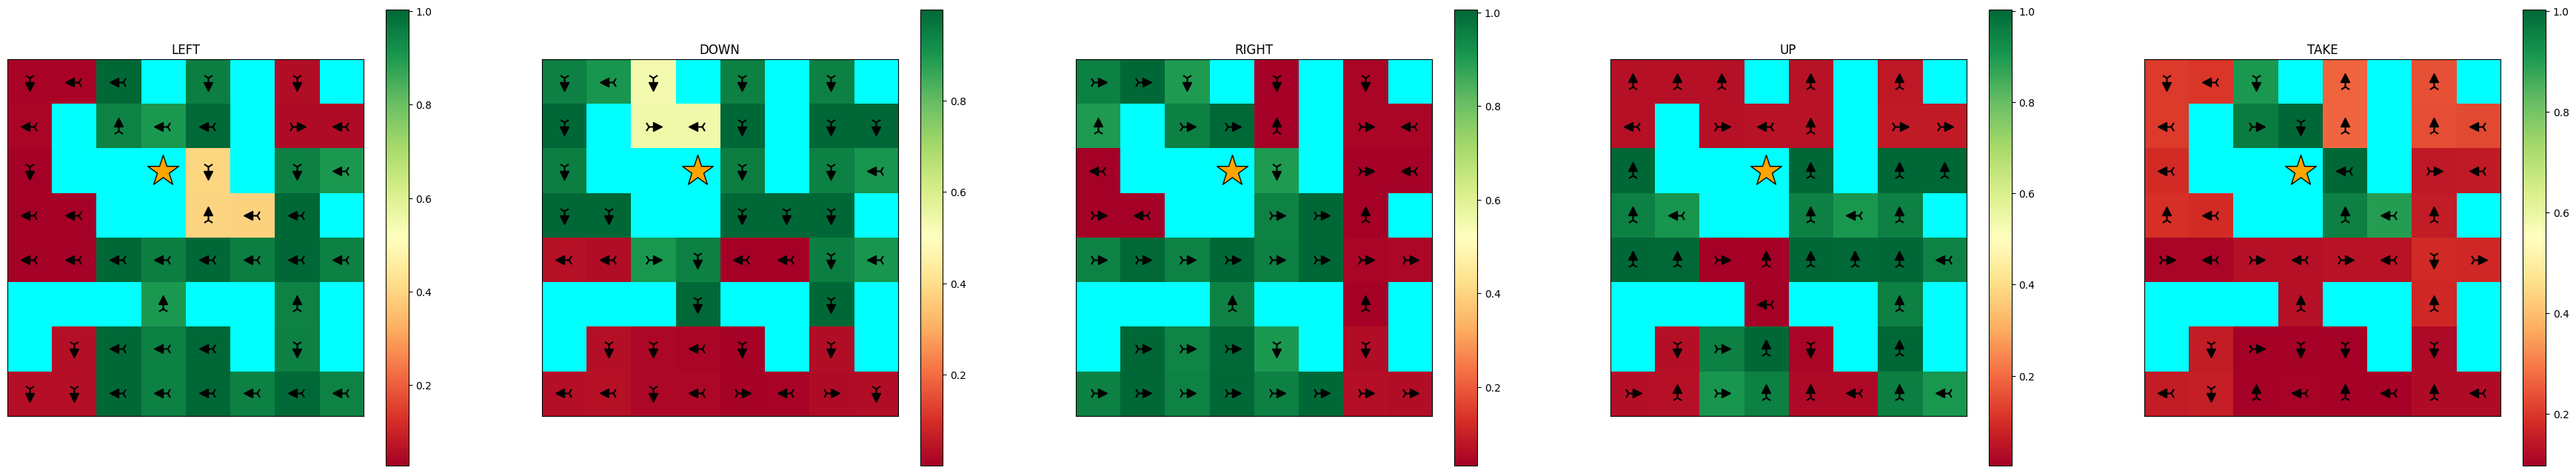

  0%|          | 0/16384 [00:00<?, ?it/s]

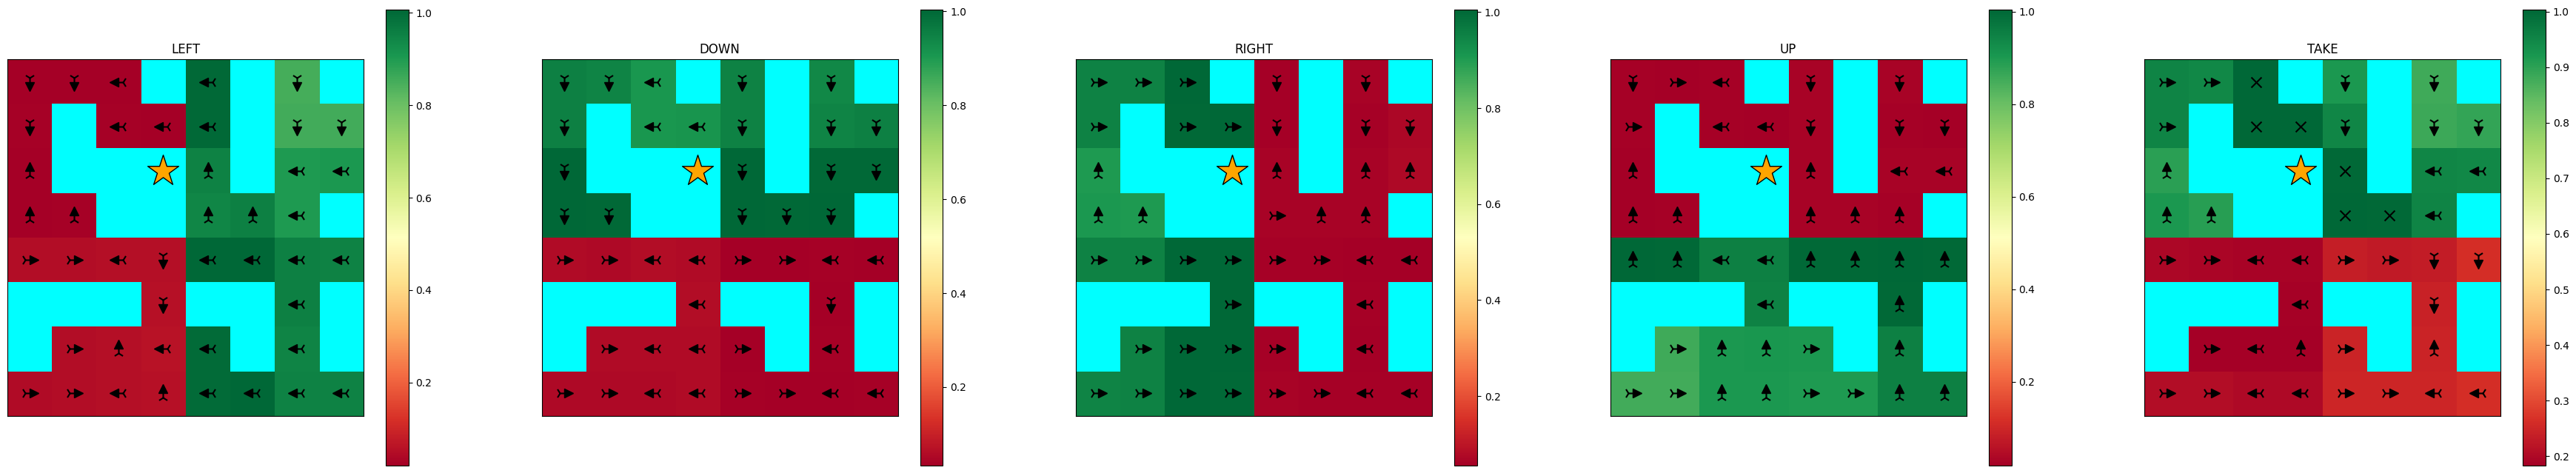

  0%|          | 0/16384 [00:00<?, ?it/s]

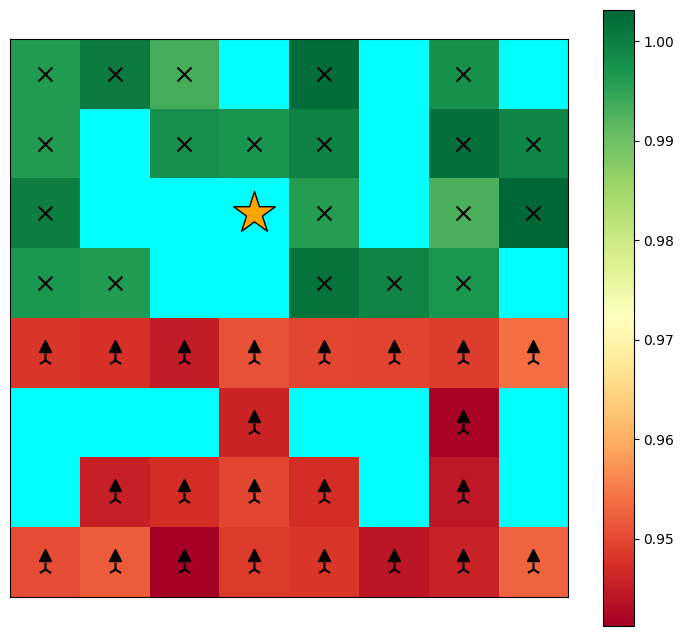

In [4]:
abs_env = env
for cell_scale in range(1, map_scale):
    # inner stages
    reward_fn = partial(actions.reward_fn, cell_scale)
    beta_fn = partial(actions.beta_fn, cell_scale)

    qnet = MultiMLP(abs_env.action_space.n)
    dql_state = qlearning.MultiDQLTrainState.create(
        rng_init, qnet, abs_env, reward_fn=reward_fn, beta_fn=beta_fn
    )

    pbar = tqdm(range(n_rollouts))
    dql_state, rewards = jax.lax.scan(partial(sim_step, abs_env, pbar=pbar), dql_state, rng_steps)

    get_qval_fn = jax.jit(lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs))
    plotting.plot_qvals(env, get_qval_fn, tasks=["LEFT", "DOWN", "RIGHT", "UP", "TAKE"])

    abs_env = mangoenv.MangoEnv(abs_env, dql_state, max_steps=4)
    rollout_steps = rollout_steps // 2

# outer stage
qnet = utils.MLP(abs_env.action_space.n)
dql_state = qlearning.DQLTrainState.create(rng_init, qnet, abs_env)

pbar = tqdm(range(n_rollouts))
dql_state, rewards = jax.lax.scan(partial(sim_step, abs_env, pbar=pbar), dql_state, rng_steps)

get_qval_fn = jax.jit(lambda obs: dql_state.qval_apply_fn(dql_state.params_qnet, obs))
plotting.plot_qvals(env, get_qval_fn)